In [1]:
import sys
sys.path.append('../scripts/')
from my_robot import*
from scipy.stats import multivariate_normal

In [7]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)
        
    def observation_update(self, observation):
        print(observation)

In [8]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): #パーティクルを動かすメソッド
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation):
        for p in self.particles: p.observation_update(observation)
    
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles] #全パーティクルの座標をリスト化
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] #向きをベクトルで表したときの座標成分のリストを作成
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5)) #描画

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
a = EstimationAgent(0.1, 0.2, 10.0/180*math.pi, estimator)
estimator.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[0.01670326 0.00015894 0.01903051]
[0.02063949 0.00023096 0.02237936]
[0.02134122 0.0001565  0.01466633]
[0.02154678 0.00022165 0.02057298]
[0.02081073 0.00017431 0.01675173]
[0.01723386 0.00016323 0.01894278]
[0.02446122 0.00014891 0.0121752 ]
[0.02055834 0.0001889  0.01837609]
[0.01982469 0.00022559 0.02275732]
[2.27425670e-02 8.83843803e-05 7.77255578e-03]
[0.01930462 0.00013513 0.01399992]
[0.01839208 0.00014003 0.01522671]
[0.01724563 0.00018851 0.02186126]
[1.96137782e-02 5.81572617e-05 5.93022828e-03]
[0.01778744 0.00012325 0.01385759]
[0.02582432 0.00034877 0.02700934]
[0.01577675 0.00011517 0.0145993 ]
[2.00472896e-02 7.71799045e-05 7.69974642e-03]
[0.01985871 0.00020552 0.02069791]
[0.02101297 0.00021323 0.02029447]
[0.02126891 0.00019008 0.01787388]
[0.01858799 0.00011851 0.01275084]
[0.0202652  0.00016733 0.01651411]
[0.02039673 0.00015726 0.01542002]
[0.02183857 0.00025433 0.02329106]
[0.02086431 0.00021383 0.02049603]
[0.02012131 0.00019671 0.01955147]
[0.01913153 0.00021

<IPython.core.display.Javascript object>


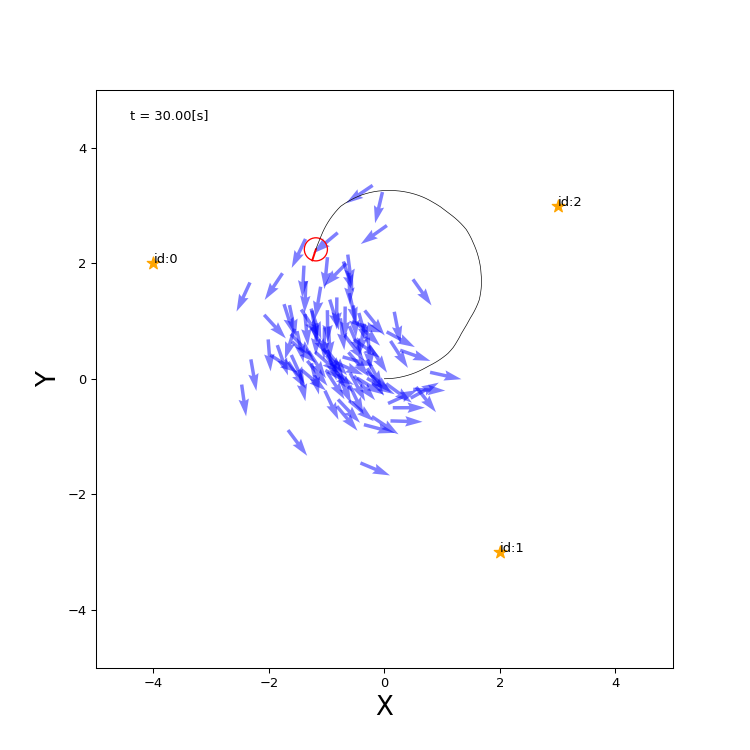

In [6]:
def trial(): ###mcl_obs_prepare
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T   #初期位置を原点に
    estimator = Mcl(initial_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator) #EstimationAgentに
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
trial()